we will use the Silhouette coefficient in this case in order to compare and choose the best clustering technique and the optimal number of clusters for your data.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from datetime import datetime
import warnings
import sys
import os

sep=\t Useful because the CSV file is separated by tabs

In [2]:
df = pd.read_csv('marketing.csv', sep='\t')

In [3]:
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
print(f'Data set shape is: {df.shape}')

Data set shape is: (2240, 29)


Enhancing the performance of memory usage


In [6]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage"""
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of DataFrame is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df = reduce_mem_usage(df)

Memory usage of DataFrame is 0.50 MB
Memory usage after optimization is: 0.11 MB
Decreased by 78.0%


NOW FEATURE GENERATION PART

In [8]:
df['Age'] = datetime.now().year - df['Year_Birth']  # Client Age

In [9]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,66
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,69
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,58
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,3,11,0,39
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,3,11,0,42


The purpose of this code below is to calculate and store the number of years since customer registration in the dataframe df by using their date of customer registration and the current date

In [10]:

def get_different_year():
    registration_year = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y').apply(lambda x: x.year)
    current_year = datetime.now().year
    return current_year - registration_year

df['Years_Since_Registration'] = get_different_year()  # Number of years since customer registration

In [11]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Years_Since_Registration
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,3,11,1,66,11
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,3,11,0,69,9
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,3,11,0,58,10
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,3,11,0,39,9
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,3,11,0,42,9


In [12]:
df["Education"] = df["Education"].replace({"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3})
# Encoded in numbers in order

In [13]:
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

step_2 = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})
step_2 = step_2.astype(int)
df['Kidhome'] = df['Kidhome'].astype(int)
df['Teenhome'] = df['Teenhome'].astype(int)

df["Family_Size"] = step_2 + df['Kidhome'] + df['Teenhome']  # Total number of people in the family

df = pd.concat([df, pd.get_dummies(df['Marital_Status'])], axis=1)  # Separate features for Alone and Partner

In [14]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Years_Since_Registration,Family_Size,Alone,Partner
0,5524,1957,1,Alone,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,66,11,1,1,0
1,2174,1954,1,Alone,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,69,9,3,1,0
2,4141,1965,1,Partner,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,58,10,2,0,1
3,6182,1984,1,Partner,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,39,9,3,0,1
4,5324,1981,3,Partner,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,42,9,3,0,1


In [15]:
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)  # Total amount spent on products

In [16]:
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                     'Response']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].sum(axis=1)  
# Number of companies in which the client accepted the offer


In [17]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_CostContact,Z_Revenue,Response,Age,Years_Since_Registration,Family_Size,Alone,Partner,Sum_Mnt,Num_Accepted_Cmp
0,5524,1957,1,Alone,58138.0,0,0,04-09-2012,58,635,...,3,11,1,66,11,1,1,0,1617,1
1,2174,1954,1,Alone,46344.0,1,1,08-03-2014,38,11,...,3,11,0,69,9,3,1,0,27,0
2,4141,1965,1,Partner,71613.0,0,0,21-08-2013,26,426,...,3,11,0,58,10,2,0,1,776,0
3,6182,1984,1,Partner,26646.0,1,0,10-02-2014,26,11,...,3,11,0,39,9,3,0,1,53,0
4,5324,1981,3,Partner,58293.0,1,0,19-01-2014,94,173,...,3,11,0,42,9,3,0,1,422,0


In [18]:
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)  # Total number of purchases

In [19]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_Revenue,Response,Age,Years_Since_Registration,Family_Size,Alone,Partner,Sum_Mnt,Num_Accepted_Cmp,Num_Total_Purchases
0,5524,1957,1,Alone,58138.0,0,0,04-09-2012,58,635,...,11,1,66,11,1,1,0,1617,1,22
1,2174,1954,1,Alone,46344.0,1,1,08-03-2014,38,11,...,11,0,69,9,3,1,0,27,0,4
2,4141,1965,1,Partner,71613.0,0,0,21-08-2013,26,426,...,11,0,58,10,2,0,1,776,0,20
3,6182,1984,1,Partner,26646.0,1,0,10-02-2014,26,11,...,11,0,39,9,3,0,1,53,0,6
4,5324,1981,3,Partner,58293.0,1,0,19-01-2014,94,173,...,11,0,42,9,3,0,1,422,0,14


EDA : Exploratory Data Analysis

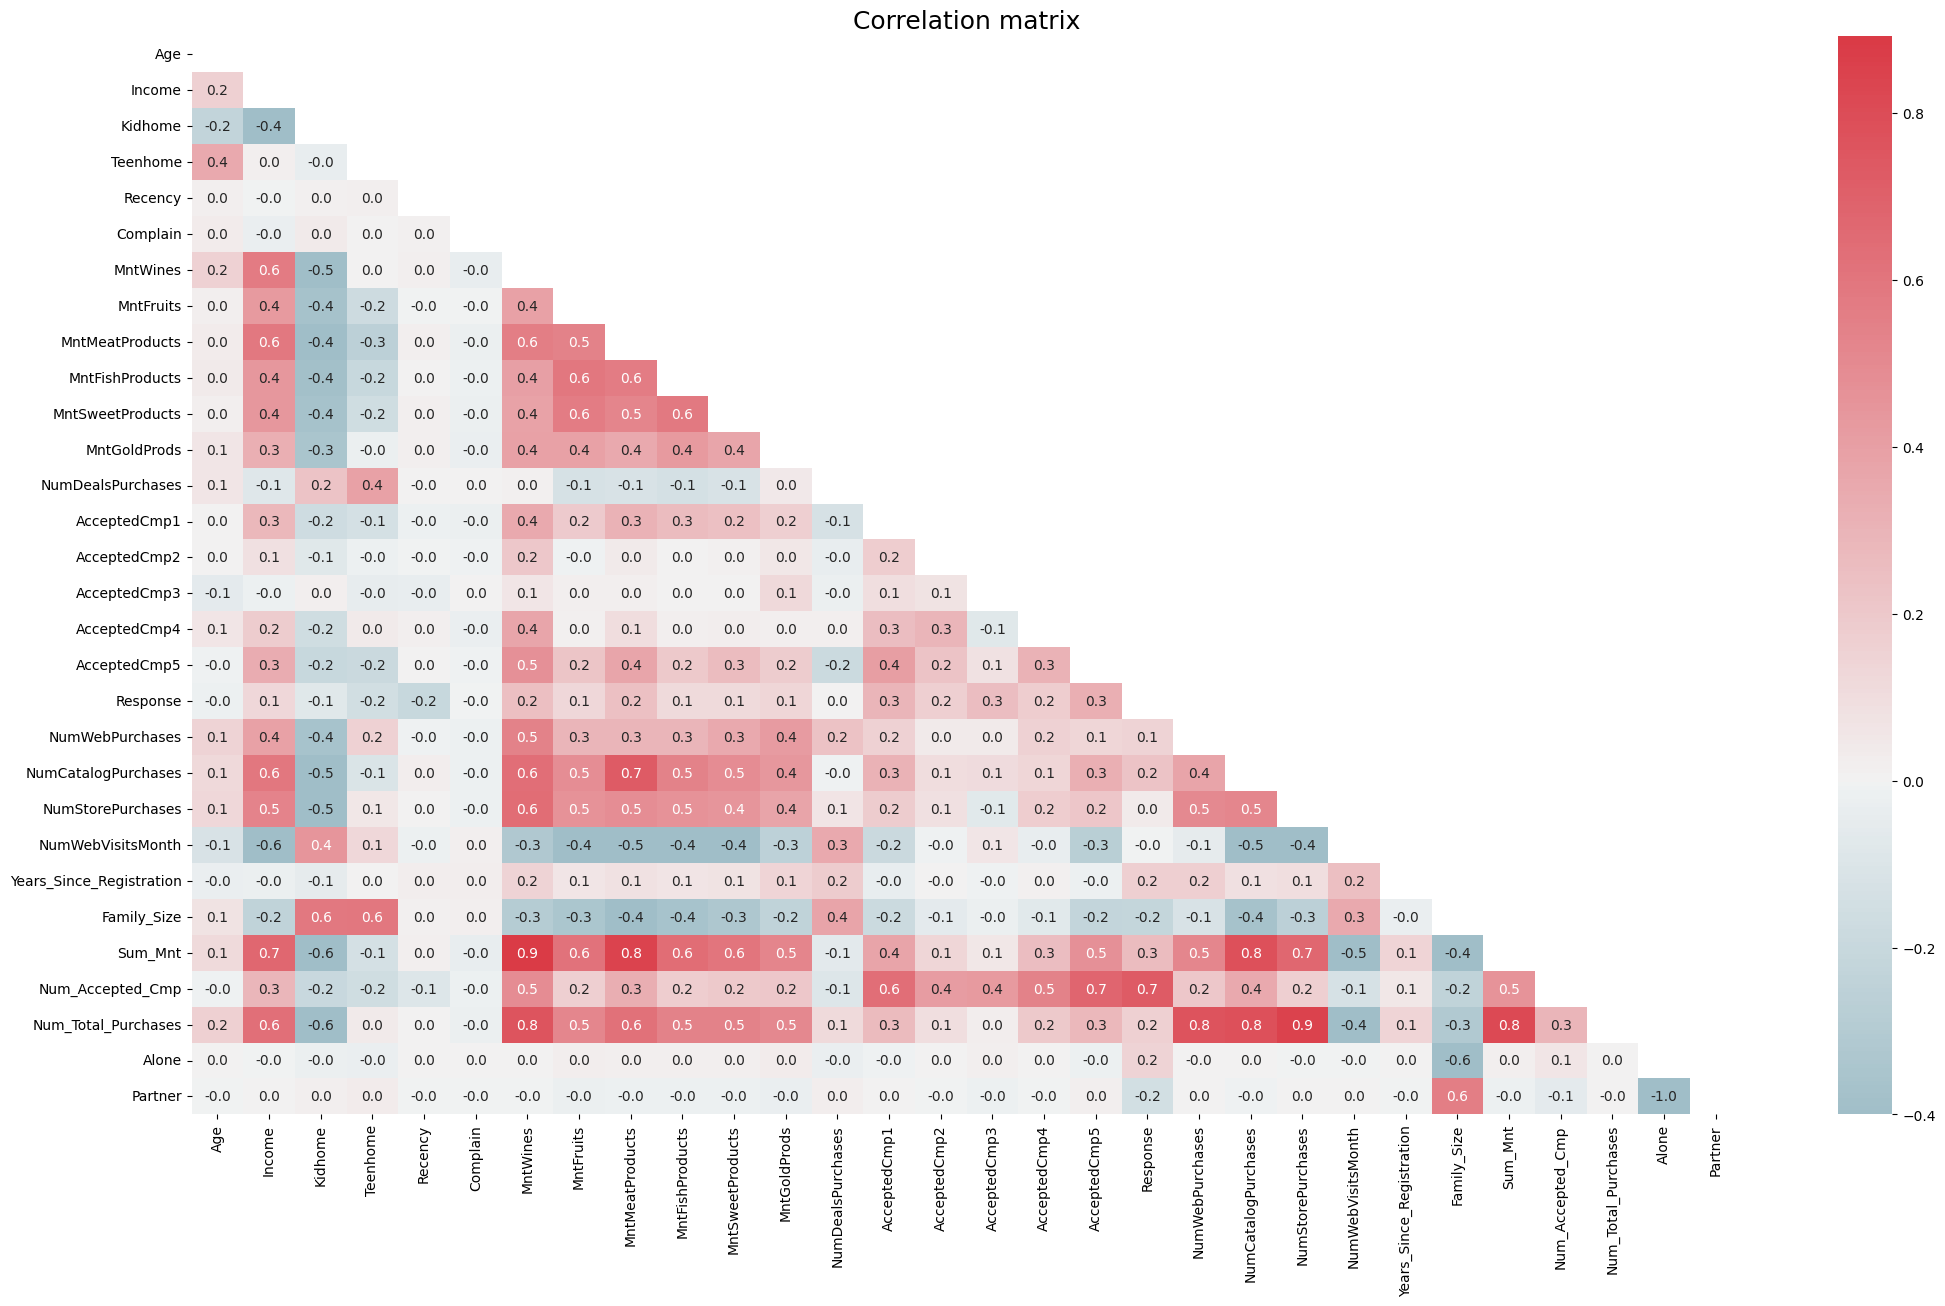

In [20]:
to_corr = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 
          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
          'MntGoldProds', 'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
          'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebPurchases', 'NumCatalogPurchases', 
          'NumStorePurchases', 'NumWebVisitsMonth', 'Years_Since_Registration', 'Family_Size',
           'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases', 'Alone', 'Partner']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()

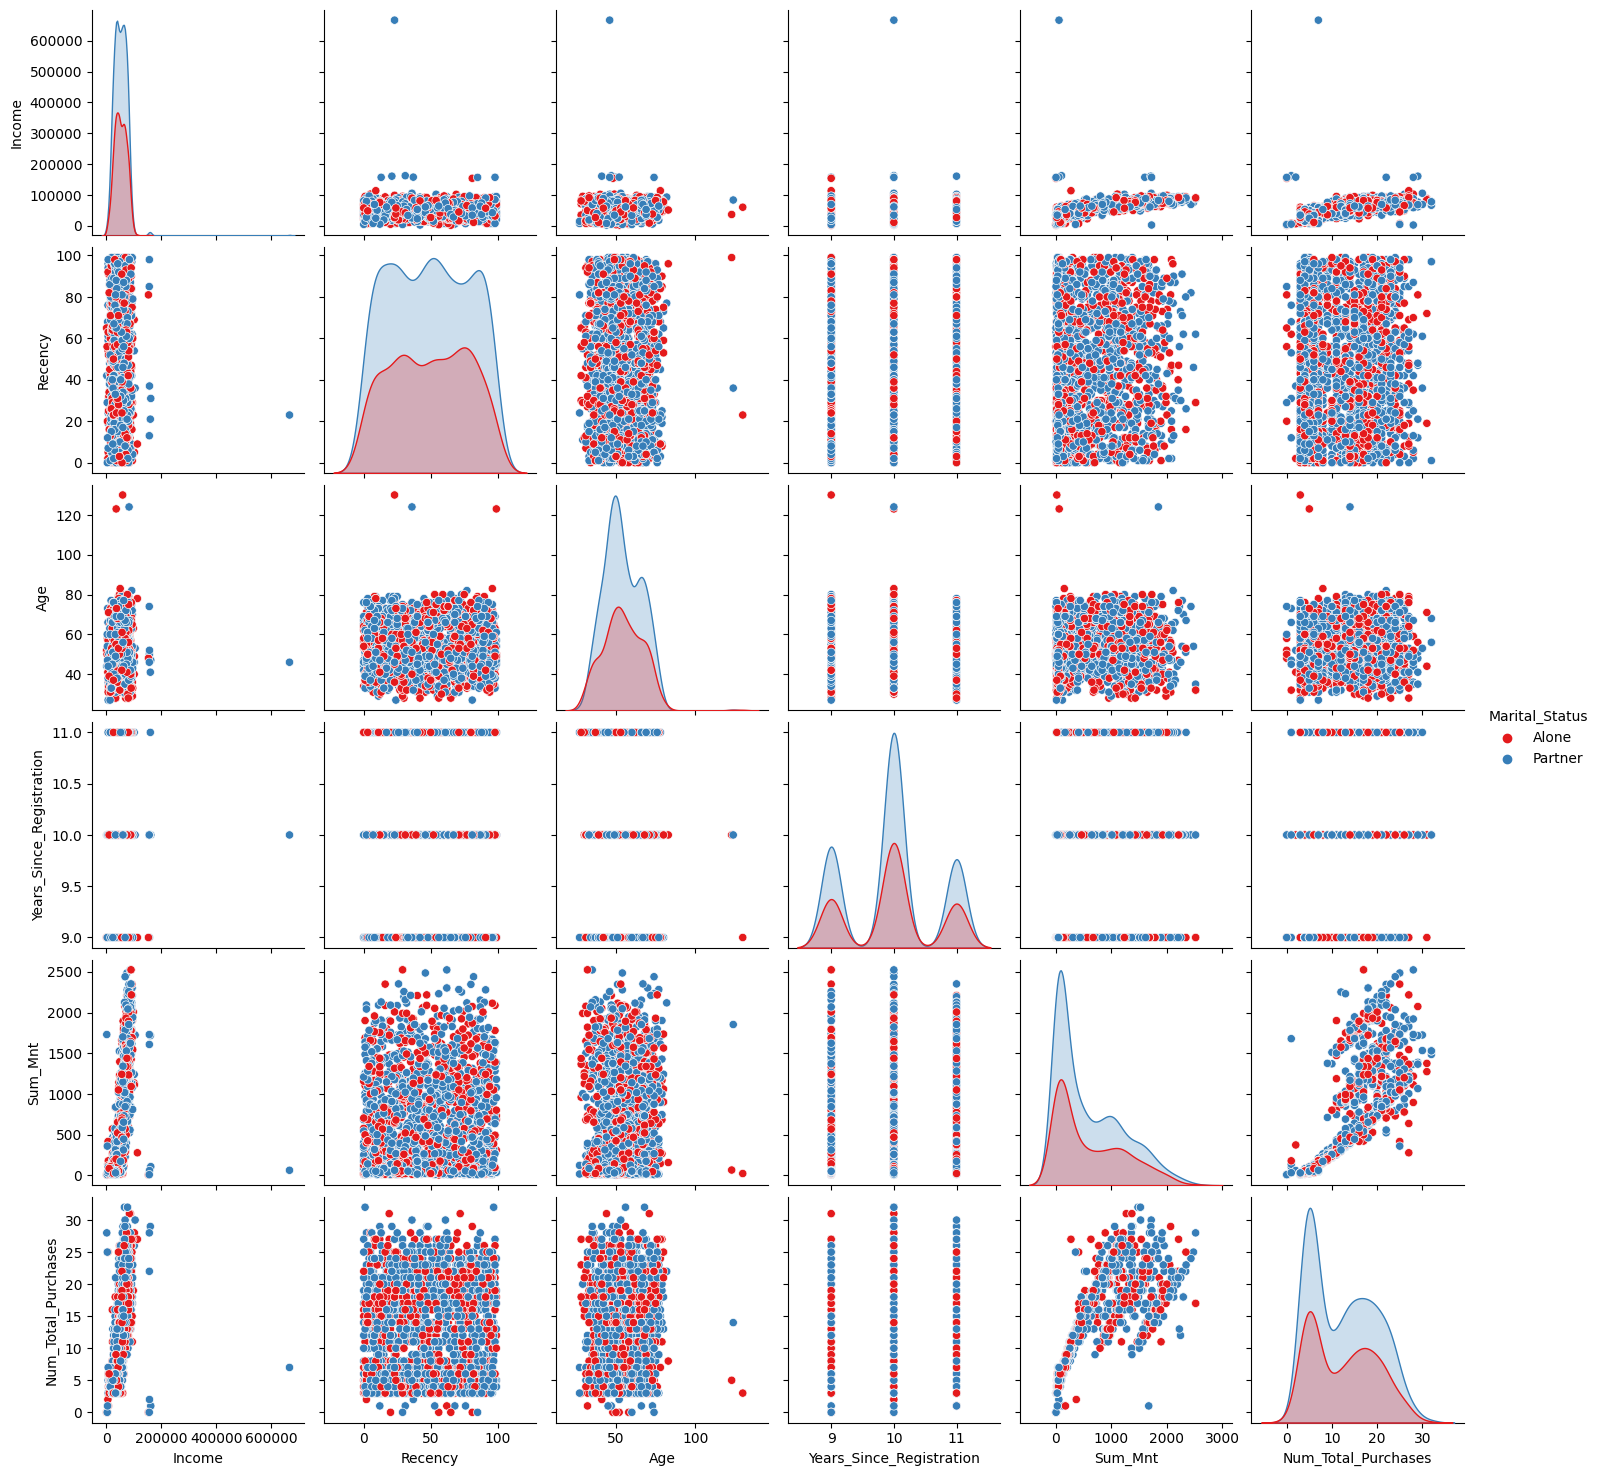

In [21]:
to_plot = ['Income', 'Recency', 'Age', 'Years_Since_Registration', 'Sum_Mnt',
           'Num_Total_Purchases', 'Marital_Status']
sns.pairplot(df[to_plot], hue='Marital_Status', palette='Set1')
plt.show()

DATA CLEANING

In [22]:
df.isna().sum()

ID                           0
Year_Birth                   0
Education                    0
Marital_Status               0
Income                      24
Kidhome                      0
Teenhome                     0
Dt_Customer                  0
Recency                      0
MntWines                     0
MntFruits                    0
MntMeatProducts              0
MntFishProducts              0
MntSweetProducts             0
MntGoldProds                 0
NumDealsPurchases            0
NumWebPurchases              0
NumCatalogPurchases          0
NumStorePurchases            0
NumWebVisitsMonth            0
AcceptedCmp3                 0
AcceptedCmp4                 0
AcceptedCmp5                 0
AcceptedCmp1                 0
AcceptedCmp2                 0
Complain                     0
Z_CostContact                0
Z_Revenue                    0
Response                     0
Age                          0
Years_Since_Registration     0
Family_Size                  0
Alone   

In [23]:
df.dropna(inplace=True)  # Removed objects with gaps in income

In [24]:
df.isna().sum()

ID                          0
Year_Birth                  0
Education                   0
Marital_Status              0
Income                      0
Kidhome                     0
Teenhome                    0
Dt_Customer                 0
Recency                     0
MntWines                    0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Z_CostContact               0
Z_Revenue                   0
Response                    0
Age                         0
Years_Since_Registration    0
Family_Size                 0
Alone                       0
Partner   

Quartiles method to remove Outliers

In [25]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Income')

Remove unnecessary features

In [26]:
df.drop(['Year_Birth', 'ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Marital_Status'], axis=1, inplace=True)

In [27]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Age,Years_Since_Registration,Family_Size,Alone,Partner,Sum_Mnt,Num_Accepted_Cmp,Num_Total_Purchases
0,1,58138.0,0,0,58,635,88,546,172,88,...,0,1,66,11,1,1,0,1617,1,22
1,1,46344.0,1,1,38,11,1,6,2,1,...,0,0,69,9,3,1,0,27,0,4
2,1,71613.0,0,0,26,426,49,127,111,21,...,0,0,58,10,2,0,1,776,0,20
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,0,39,9,3,0,1,53,0,6
4,3,58293.0,1,0,94,173,43,118,46,27,...,0,0,42,9,3,0,1,422,0,14


Data scaling (Normalization | Standartization)

In [28]:
def scaling_func(df: pd.DataFrame) -> None:
    mms = MinMaxScaler()
    return pd.DataFrame(data=mms.fit_transform(df), columns=df.columns)


df_scaled = scaling_func(df)
df_scaled.index = df.index  # for convenient work with dataframes

Dimensionality reduction

In [29]:
def dim_reduction(data: pd.DataFrame) -> pd.DataFrame:
    n_components = 8
    pca = PCA(n_components=n_components, random_state=42)
    data = pd.DataFrame(pca.fit_transform(data), columns =([f'PC{i}' for i in range(1, n_components + 1)]))
    return data

df_transform = dim_reduction(df_scaled)  # df: scaling + dimensionality reduction
df_transform.index = df_scaled.index  # for convenient work with dataframes

NOW Clustering


steps: feature generation -> data cleaning -> data scaling(normalization) -> Dimensionality reduction(PCA)  -> Clustering


We will apply clustering algorithms for df_transform, based on this we will get labels for all objects, then we will combine the label column for objects with df in order to get information about clusters (on graphs).

In this work, the following clustering algorithms will be used: (https://scikit-learn.org/stable/modules/clustering.html)

K-means ++
Aglomerative clustering
Spectral clustering
It is noteworthy that in these algorithms it is necessary to pre-specify the number of clusters.
We assume that the minimum number of clusters is two, the maximum number of clusters is eight. Based on this, for different cases of the number of clusters, we will build models.
If the metric is maximum for models with a large number of clusters, then we will iteratively increase the maximum number of clusters and build new models.

In [40]:
class Clustering: 
    algorithms = ['KMeans', 'AgglomerativeClustering', 'SpectralClustering'] 
# Define a list of algorithms that will be used for clustering 
    min_n_clusters = 2 
# Define the minimum number of clusters that will be tried 
    max_n_clusters = 8 
# Define the maximum number of clusters that will be tried 
    kmeans_distortions = [] 
# Define a list that will store the distortions for different numbers of clusters for KMeans algorithm.
#  Distortion is a measure of how much the data points deviate from their assigned cluster centers.

    @staticmethod # This is a decorator that indicates that the following method is a static method. A static method is a method that belongs to the class but does not depend on any instance or attribute of the class. It can be called without creating an instance of the class.
    def sse_plot(): # Define a static method called sse_plot that will plot the distortions for KMeans algorithm
        """Graphs for the SSE values (KMeans)""" 
        plt.figure(figsize=(25, 8)) # Create a figure with a specified size using matplotlib.pyplot library
        sns.set_style("darkgrid") # Set the style of the plot using seaborn library
        plt.title('Distortion values for different number of clusters (for Kmeans)', fontsize=14, fontweight='bold') # Set the title of the plot with some formatting options
        plt.xlabel('Clusters', fontsize=14, fontweight='bold') # Set the label of the x-axis with some formatting options
        plt.ylabel('SSE',fontsize=14, fontweight='bold') # Set the label of the y-axis with some formatting options
        plt.xticks(fontsize=14) # Set the size of the tick labels on the x-axis
        plt.yticks(fontsize=14) # Set the size of the tick labels on the y-axis
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), Clustering.kmeans_distortions, marker='o') # Plot the distortions as a line with circle markers using the list of numbers from min_n_clusters to max_n_clusters as x-values and the list of distortions as y-values
        plt.show() # Show the plot

    @staticmethod # Another static method decorator
    def silhouette_result(metrics_score:list, algorithm: str): # Define a static method called silhouette_result that will plot the silhouette scores for different numbers of clusters for any algorithm. Silhouette score is a measure of how well the data points are clustered and how distinct the clusters are from each other. It ranges from -1 to 1, with higher values indicating better clustering.
        plt.figure(figsize=(25, 8)) # Create another figure with a specified size
        sns.set_style("darkgrid") # Set the style again
        plt.title(f'Silhouette score for different number of clusters (algorithm: {algorithm})', fontsize=14, fontweight='bold') # Set the title with some formatting options and include the name of the algorithm as a variable using f-string syntax
        plt.xlabel('Clusters', fontsize=14, fontweight='bold') # Set the label of the x-axis with some formatting options
        plt.ylabel('Silhouette', fontsize=14, fontweight='bold') # Set the label of the y-axis with some formatting options
        plt.xticks(fontsize=14) # Set the size of the tick labels on the x-axis
        plt.yticks(fontsize=14) # Set the size of the tick labels on the y-axis
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), metrics_score, marker='o') # Plot the silhouette scores as a line with circle markers using the list of numbers from min_n_clusters to max_n_clusters as x-values and the list of silhouette scores as y-values
        plt.show() # Show the plot
        print('*' * 112) # Print a line of asterisks to separate different plots

        
    def make_models(self, data_old: pd.DataFrame, data_modified: pd.DataFrame): # Define a method called make_models that will create and evaluate clustering models for different algorithms and numbers of clusters. It takes two parameters: data_old is the original data frame and data_modified is the transformed data frame that has been reduced in dimensionality and complexity using the methods PCA.
        """Method for creating models""" # This is a docstring that describes what the method does
        for algorithm in Clustering.algorithms: # Loop through the list of algorithms
            metrics = []  # Define an empty list that will store the silhouette scores for different numbers of clusters for each algorithm
            for n_clusters in range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1): # Loop through the range of numbers from min_n_clusters to max_n_clusters
                if algorithm == 'AgglomerativeClustering': # If the algorithm is AgglomerativeClustering
                    ac = AgglomerativeClustering(n_clusters=n_clusters, # Create an instance of the AgglomerativeClustering class from sklearn.cluster library and pass the number of clusters as a parameter
                                                linkage='complete') # Also pass the linkage parameter as 'complete', which means that the distance between two clusters is the maximum distance between any two points in the clusters. This is one way of defining how to merge clusters in a hierarchical way.
                    pred = ac.fit_predict(df_transform) # Fit the model to the transformed data frame and predict the cluster labels for each data point. Store the labels in a variable called pred.
                    labels = pd.DataFrame(pred, columns =['Labels'], index=df.index) # Convert the labels into a pandas data frame with a column name 'Labels' and an index that matches the original data frame.
                    metrics.append(silhouette_score(df_transform, labels)) # Calculate the silhouette score for this model using the transformed data frame and the labels data frame and append it to the metrics list.
                    Clustering.object_plot(labels, pred, algorithm) # Call another method called object_plot that will plot the data points with different colors according to their cluster labels. Pass the labels data frame, the pred variable, and the algorithm name as parameters.
                    
                if algorithm == 'SpectralClustering': # If the algorithm is SpectralClustering
                    sc = SpectralClustering(n_clusters=n_clusters) # Create an instance of the SpectralClustering class from sklearn.cluster library and pass the number of clusters as a parameter. SpectralClustering is a method that uses eigenvalues and eigenvectors of a matrix that represents the similarity or affinity between data points to cluster them.
                    pred = sc.fit_predict(df_transform) # Fit the model to the transformed data frame and predict the cluster labels for each data point. Store the labels in a variable called pred.
                    labels = pd.DataFrame(pred, columns =['Labels'], index=df.index) # Convert the labels into a pandas data frame with a column name 'Labels' and an index that matches the original data frame.
                    metrics.append(silhouette_score(df_transform, labels)) # Calculate the silhouette score for this model using the transformed data frame and the labels data frame and append it to the metrics list.
                    Clustering.object_plot(labels, pred, algorithm) # Call another method called object_plot that will plot the data points with different colors according to their cluster labels. Pass the labels data frame, the pred variable, and the algorithm name as parameters.
                                            
                if algorithm == 'KMeans':  # If the algorithm is KMeans
                    kmeans = KMeans(n_clusters=n_clusters,  # Create an instance of the KMeans class from sklearn.cluster library and pass the number of clusters as a parameter. KMeans is a method that randomly initializes some points as cluster centers and then assigns each data point to its nearest center. It then updates the centers by taking the mean of all points in each cluster and repeats this process until convergence or a maximum number of iterations is reached.
                                    init="k-means++",  # Also pass the init parameter as "k-means++", which means that the initial cluster centers are chosen in a smart way to speed up convergence.
                                    n_init=10, # Also pass the n_init parameter as 10, which means that the algorithm will run 10 times with different initial centers and choose the best one based on distortion.
                                    max_iter=280,  # Also pass the max_iter parameter as 280, which means that the maximum number of iterations for each run is 280.
                                    random_state=42) # Also pass the random_state parameter as 42, which means that a fixed seed will be used for random number generation. This ensures reproducibility of results.
                    pred = kmeans.fit_predict(df_transform)  # Fit the model to the transformed data frame and predict the cluster labels for each data point. Store them in a variable called pred.
                    labels = pd.DataFrame(pred, columns=['Labels'], index=df.index) # Convert them into a pandas

    @staticmethod
    def object_plot(labs: pd.DataFrame, predict: np.array, algorithm: str):
        """Plot cluster size and silhouette coefficient"""
        # Group the labels data frame by the ‘Labels’ column and get the size of each group.
        # This will give the number of objects in each cluster. Store it in a variable called cluster_group.
        cluster_group = labs.groupby('Labels').size()

        # Create a figure with a specified size
        plt.figure(figsize=(25, 5))
        
        # Create a subplot with one row and two columns and select the first one
        plt.subplot(1, 2, 1)
        
        # Set the style using seaborn library
        sns.set_style("darkgrid")
        
        # Set the title with some formatting options and include the name of the algorithm as a variable using f-string syntax
        plt.title(f'Cluster size (algorithm: {algorithm})', fontsize=14, fontweight='bold')
        
        # Create a horizontal bar plot using seaborn library.
        # Use the values of cluster_group as x-values and the index of cluster_group as y-values.
        # Convert the index to a list of strings using map function.
        sns.barplot(x=cluster_group.values, y=list(map(str, cluster_group.index)))
        
        # Set the label of the x-axis with some formatting options
        plt.xlabel('Number of objects', fontsize=14, fontweight='bold')
        
        # Set the label of the y-axis with some formatting options
        plt.ylabel('Clusters', fontsize=14, fontweight='bold')
        
        # Set the size of the tick labels on the x-axis
        plt.xticks(fontsize=14)
        
        # Set the size of the tick labels on the y-axis
        plt.yticks(fontsize=14)


        plt.subplot(1, 2, 2) # Select the second subplot         
        cluster_labels = np.unique(predict) # Get the unique values of predict variable using numpy library. This will give the list of cluster labels.
        silhouette_vals = silhouette_samples(df_transform, predict, metric='euclidean') # Calculate the silhouette values for each data point using sklearn.metrics library. Use df_transform as data, predict as labels, and euclidean as metric. Store them in a variable called silhouette_vals.
        y_ax_lower, y_ax_upper = 0, 0 # Initialize two variables that will keep track of the lower and upper limits of the y-axis
        yticks = [] # Initialize an empty list that will store the tick positions on the y-axis
        for i, с in enumerate(cluster_labels): # Loop through each cluster label using enumerate function that gives both index and value
            c_silhouette_vals = silhouette_vals[predict == с] # Filter silhouette_vals by selecting only those that belong to cluster c. Store them in a variable called c_silhouette_vals.
            c_silhouette_vals.sort() # Sort c_silhouette_vals in ascending order
            y_ax_upper += len(c_silhouette_vals) # Update y_ax_upper by adding the length of c_silhouette_vals
            plt.barh(range(y_ax_lower, y_ax_upper), # Create a horizontal bar plot using matplotlib.pyplot library. Use range function to generate a sequence of numbers from y_ax_lower to y_ax_upper as y-values.
                c_silhouette_vals, # Use c_silhouette_vals as x-values.
                height = 1, # Set the height of each bar as 1.
                edgecolor='none') # Set no edge color for each bar.
            yticks.append((y_ax_lower + y_ax_upper) / 2) # Append the midpoint of each bar to yticks list.
            y_ax_lower += len(c_silhouette_vals)  # Update y_ax_lower by adding the length of c_silhouette_vals.
        silhouette_avg = np.mean(silhouette_vals) # Calculate the mean of silhouette_vals using numpy library. This will give the average silhouette score for all data points. Store it in a variable called silhouette_avg.
        plt.axvline(silhouette_avg, color="red", linestyle="--") # Draw a vertical line at silhouette_avg using matplotlib.pyplot library. Use red color and dashed style for the line.
        sns.set_style("darkgrid") # Set the style again
        plt.title(f'Silhouette plot for different clusters (algorithm: {algorithm})', fontsize=14, fontweight='bold') # Set the title with some formatting options and include the name of the algorithm as a variable using f-string syntax  
        val = float(''.join([i for i in str(silhouette_avg)][0:5])) # Convert silhouette_avg to a string and then join the first five characters of it using join function. Then convert it back to a float and store it in a variable called val. This is a way of rounding the silhouette_avg to two decimal places.
        plt.xlabel(f'Silhouette = {val}', fontsize=14, fontweight='bold') # Set the label of the x-axis with some formatting options and include val as a variable using f-string syntax
        plt.ylabel('Clusters', fontsize=14, fontweight='bold') # Set the label of the y-axis with some formatting options
        plt.yticks(yticks, cluster_labels, fontsize=14) # Set the tick positions and labels on the y-axis using yticks and cluster_labels lists
        plt.show() # Show the plot
        print('*' * 112) # Print a line of asterisks to separate different plots


        clustering = Clustering() 
        # Create an instance of the Clustering class and assign it to a variable called clustering 
        clustering.make_models(df, df_transform) 
        # Call the make_models method of the clustering object and pass df and df_transform as parameters. This will create and evaluate clustering models for different algorithms and numbers of clusters


What can we say from these graphs:
Good metric results for Agglomerative and Spectral Clustering algorithms
Best Model: AgglomerativeClustering(n_clusters=3).

In [42]:
best_model = AgglomerativeClustering(n_clusters=3)
labels = pd.DataFrame(best_model.fit_predict(df_transform), columns=['Clusters'], index=df.index)
df = pd.concat([df, labels], axis=1)

In [43]:
object_cols = ['Education', 'Kidhome', 'Teenhome', 'Family_Size', 'Alone', 'Partner']
num_cols = ['Income', 'Recency', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
            'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases',
            'NumWebVisitsMonth', 'Age', 'Years_Since_Registration',
            'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases']

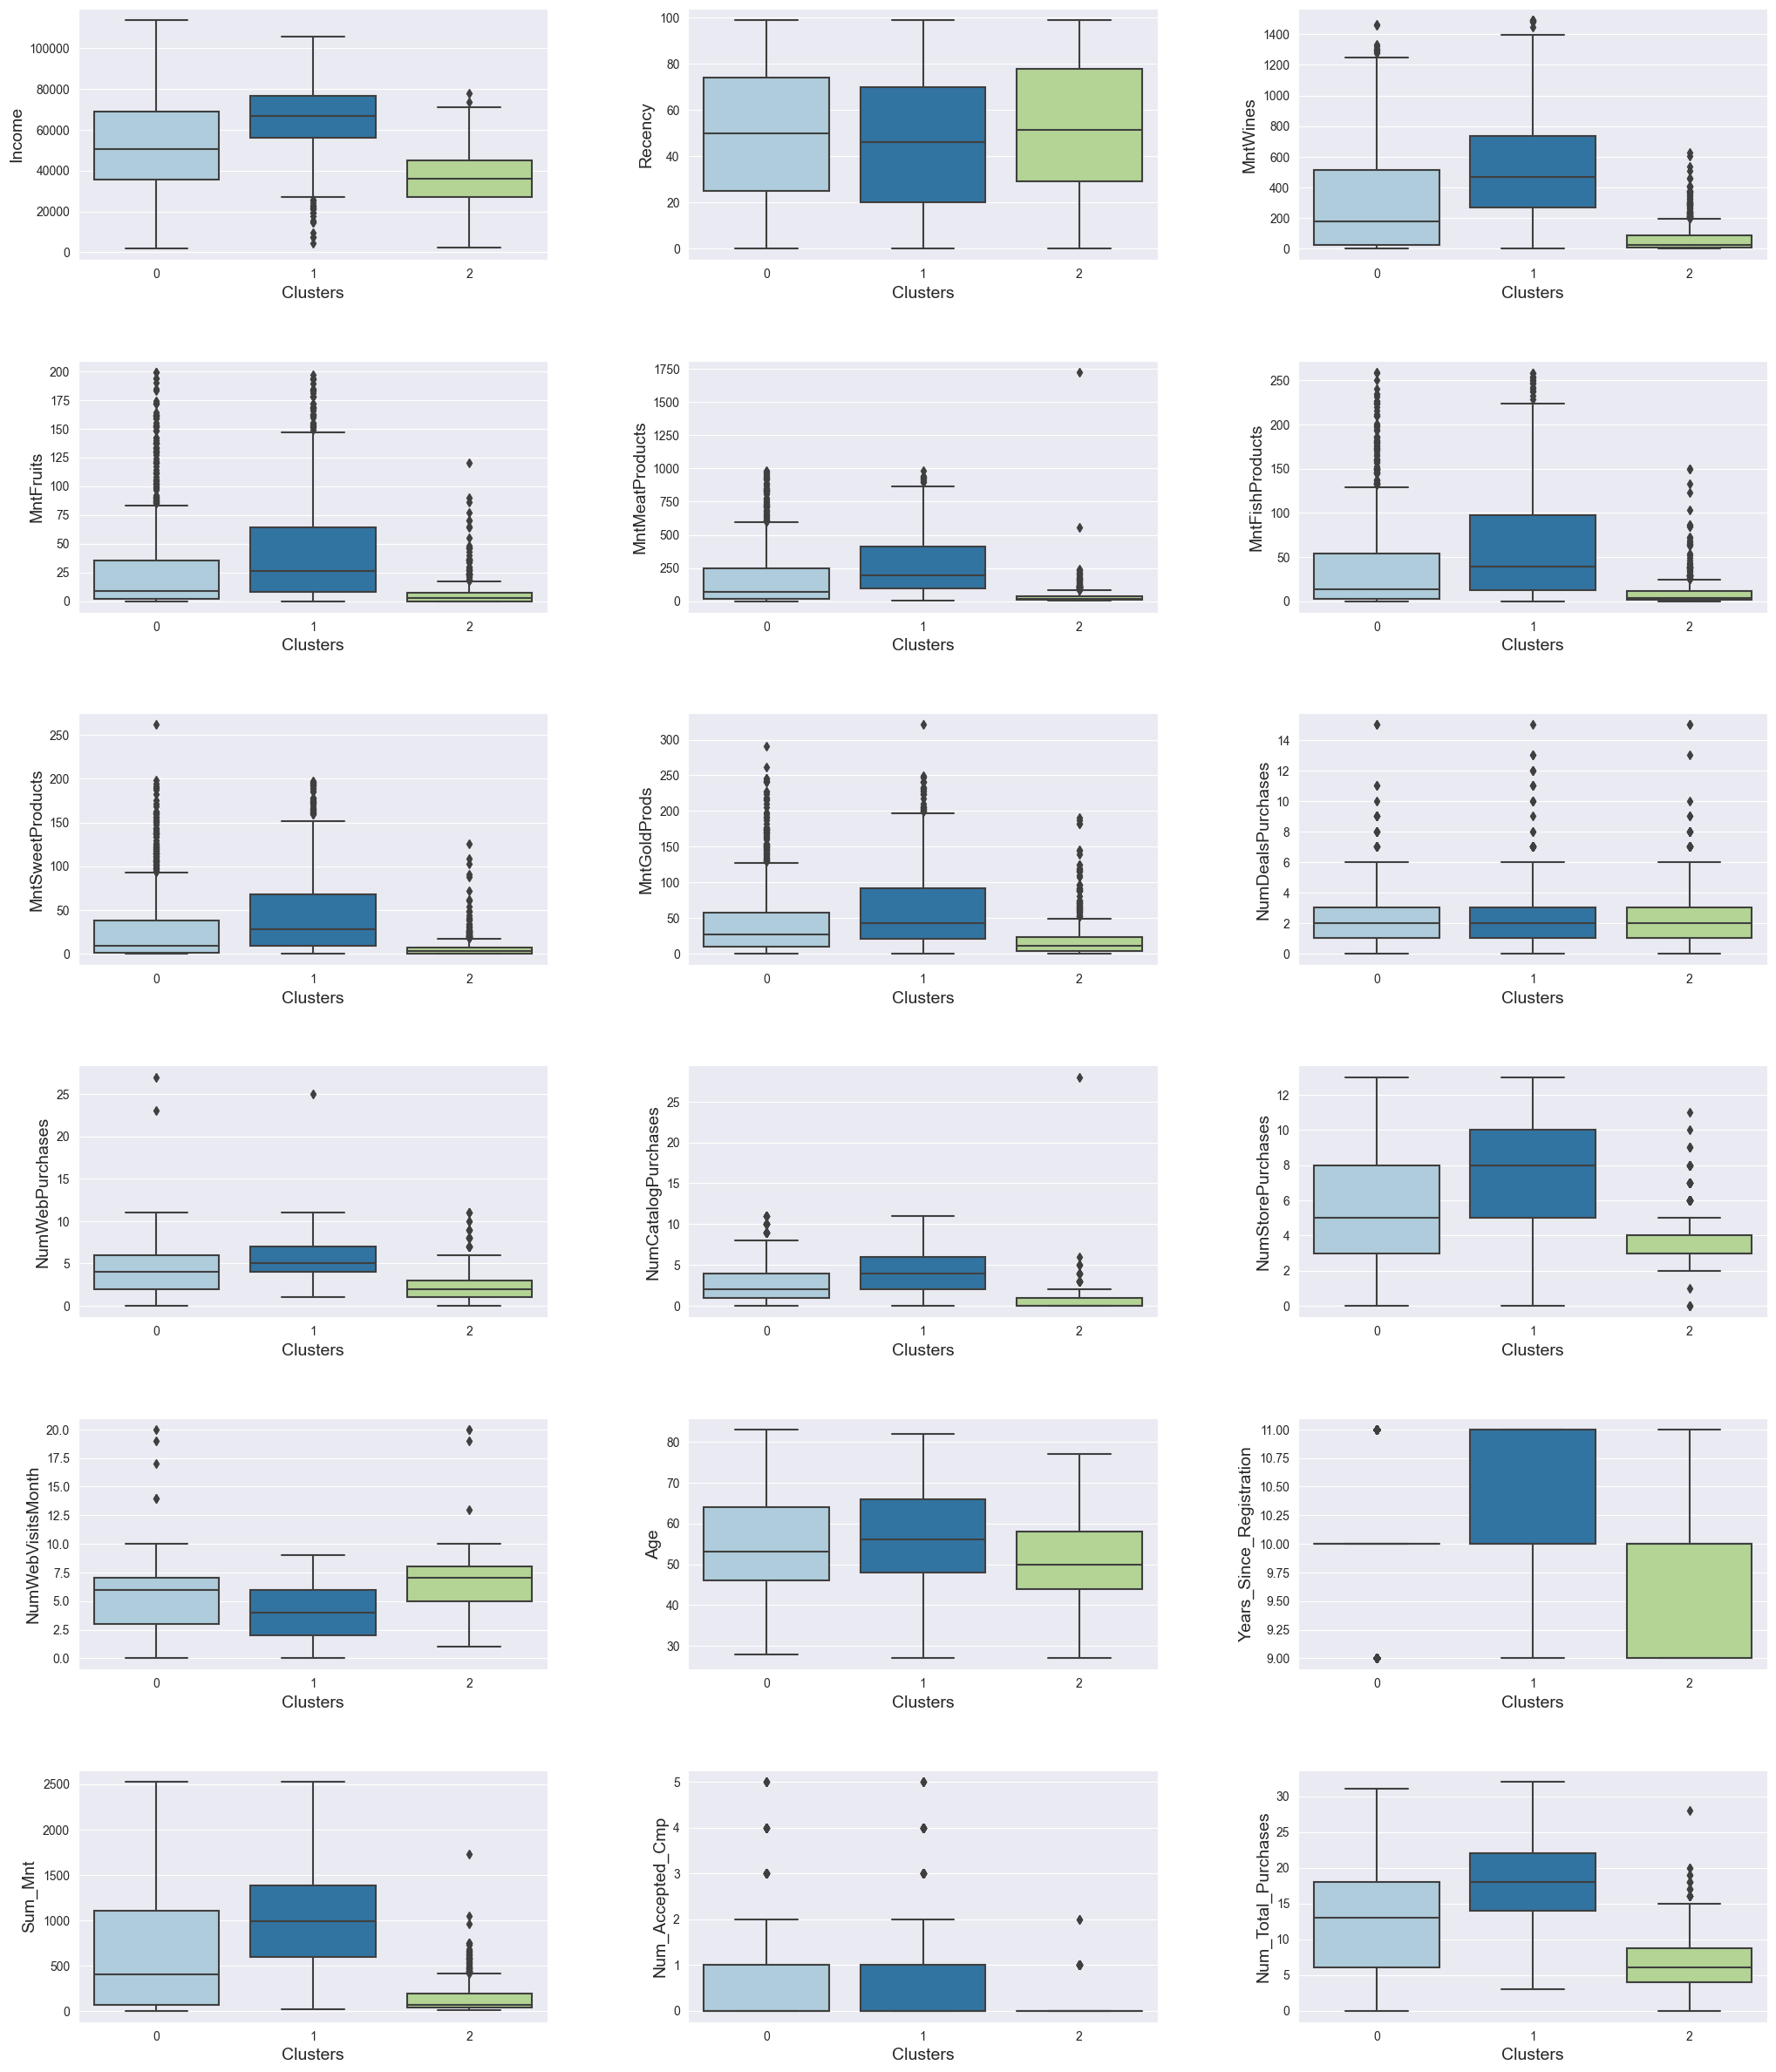

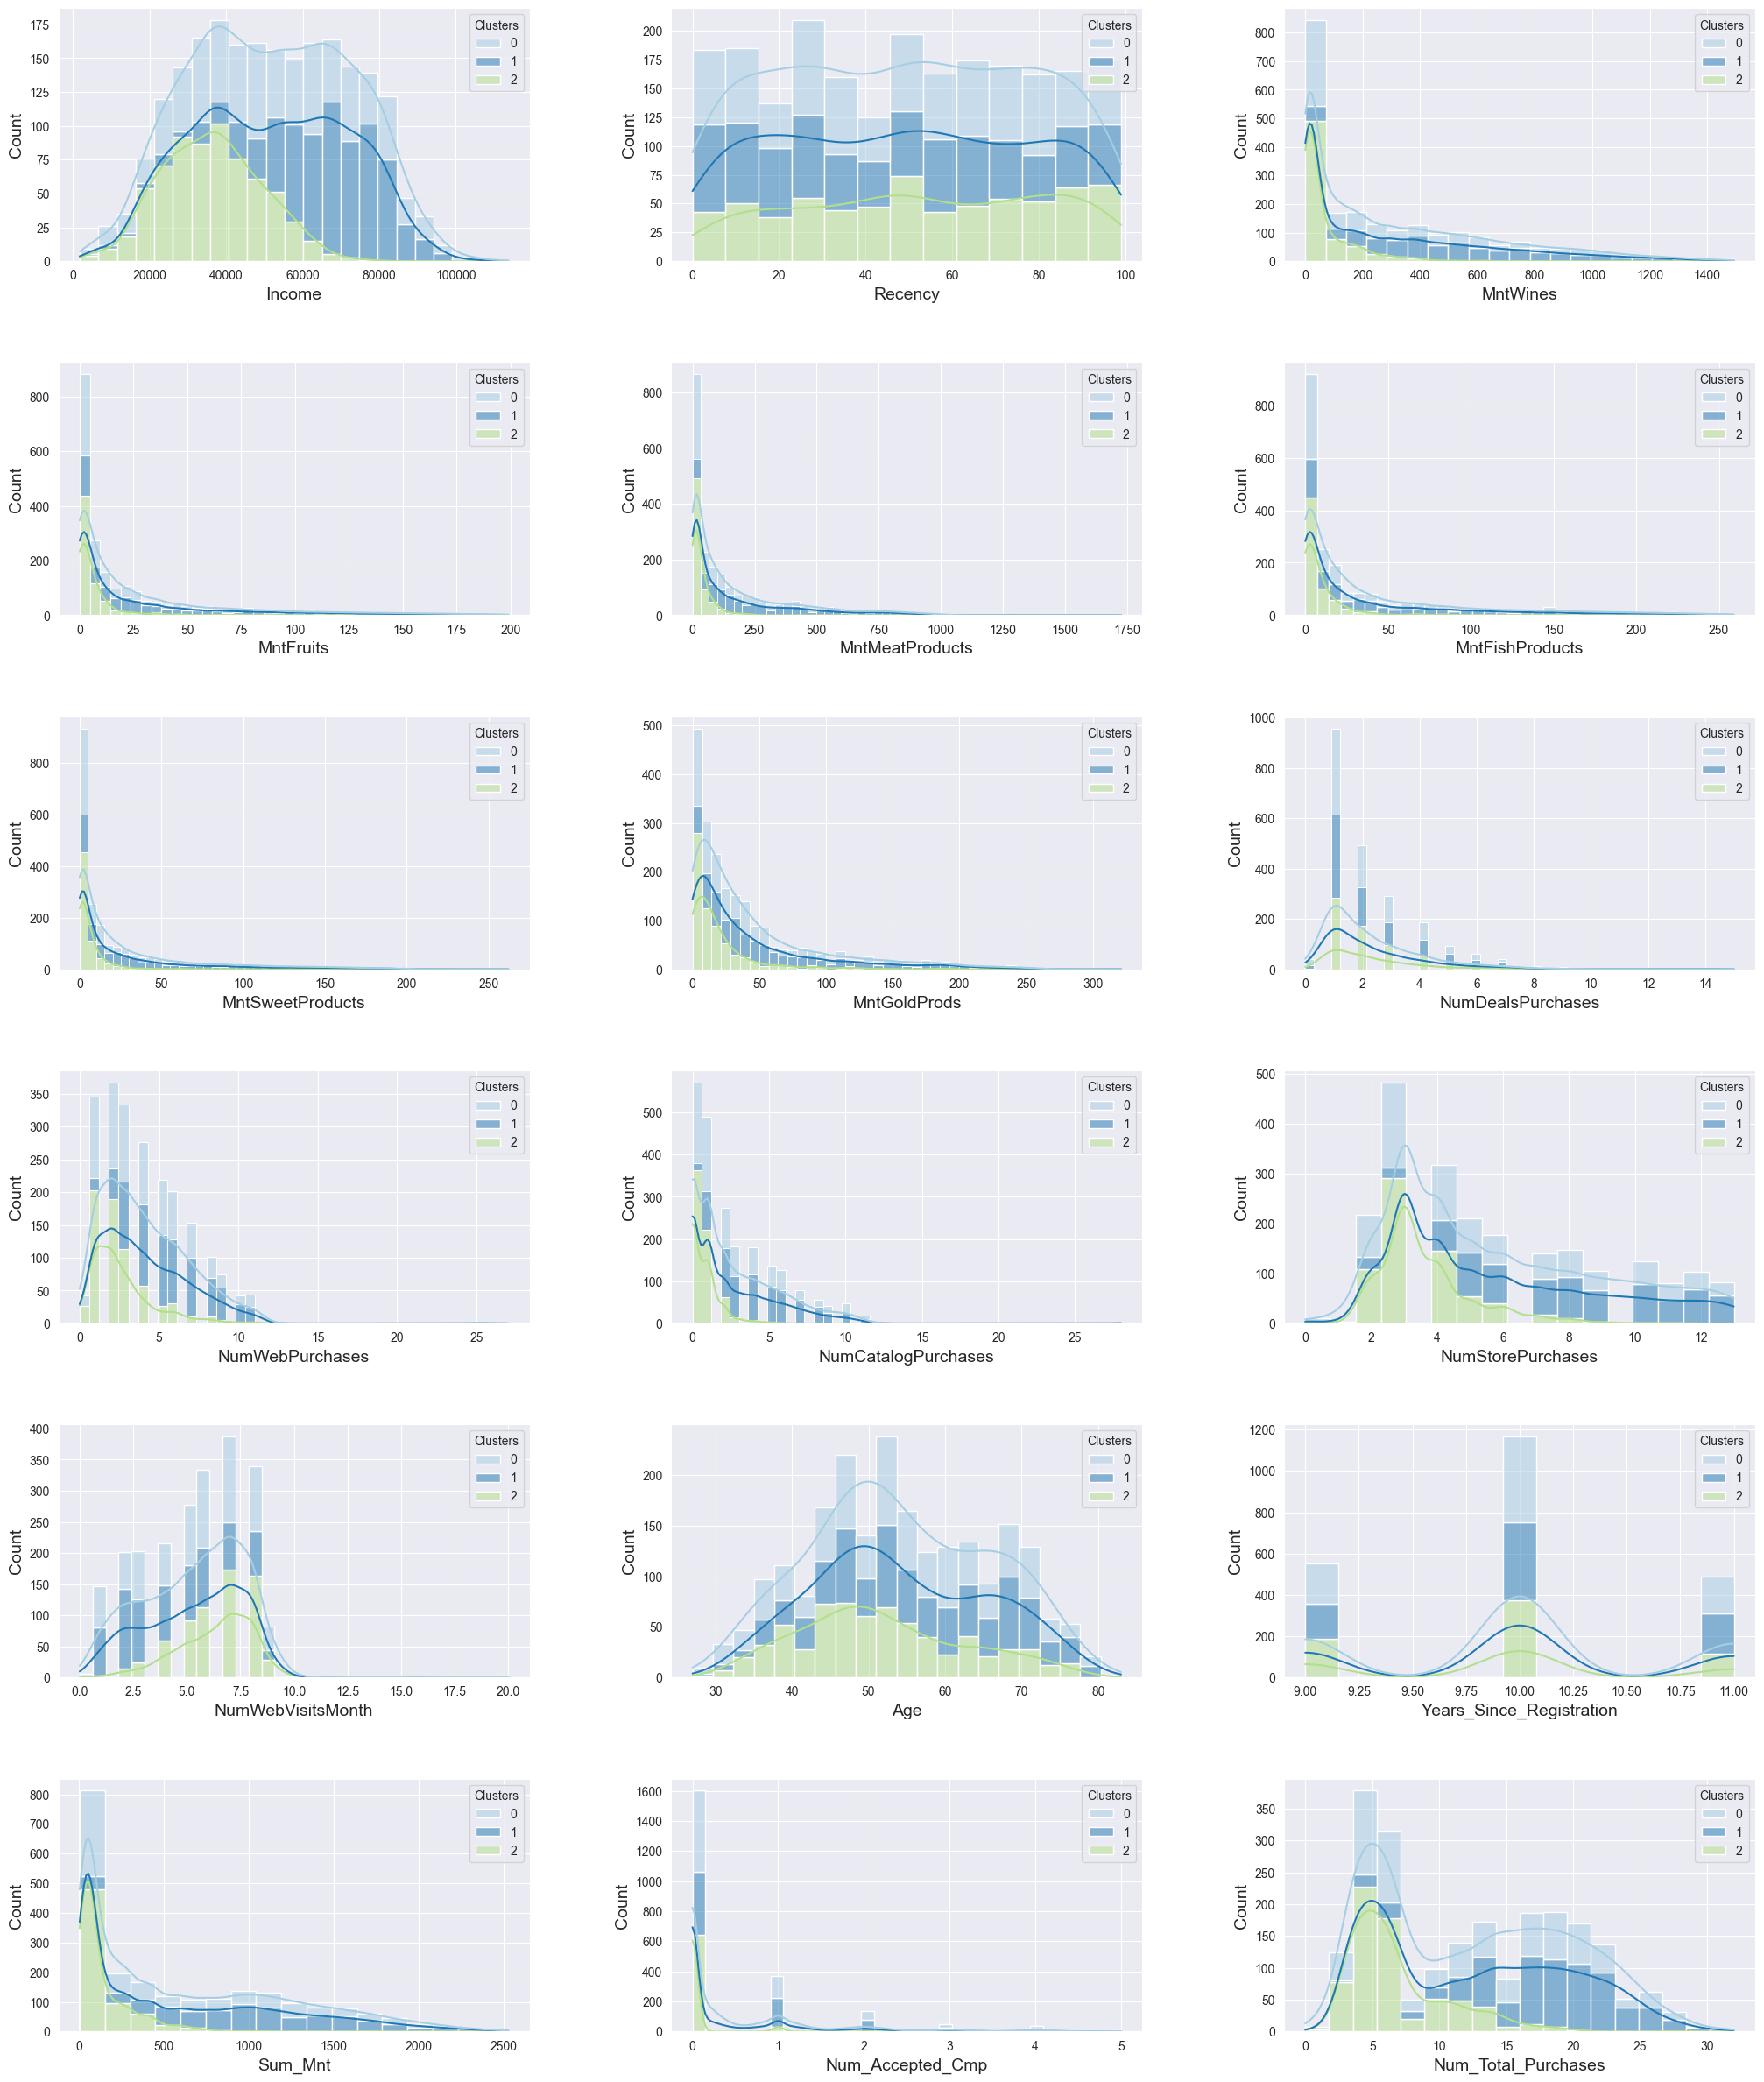

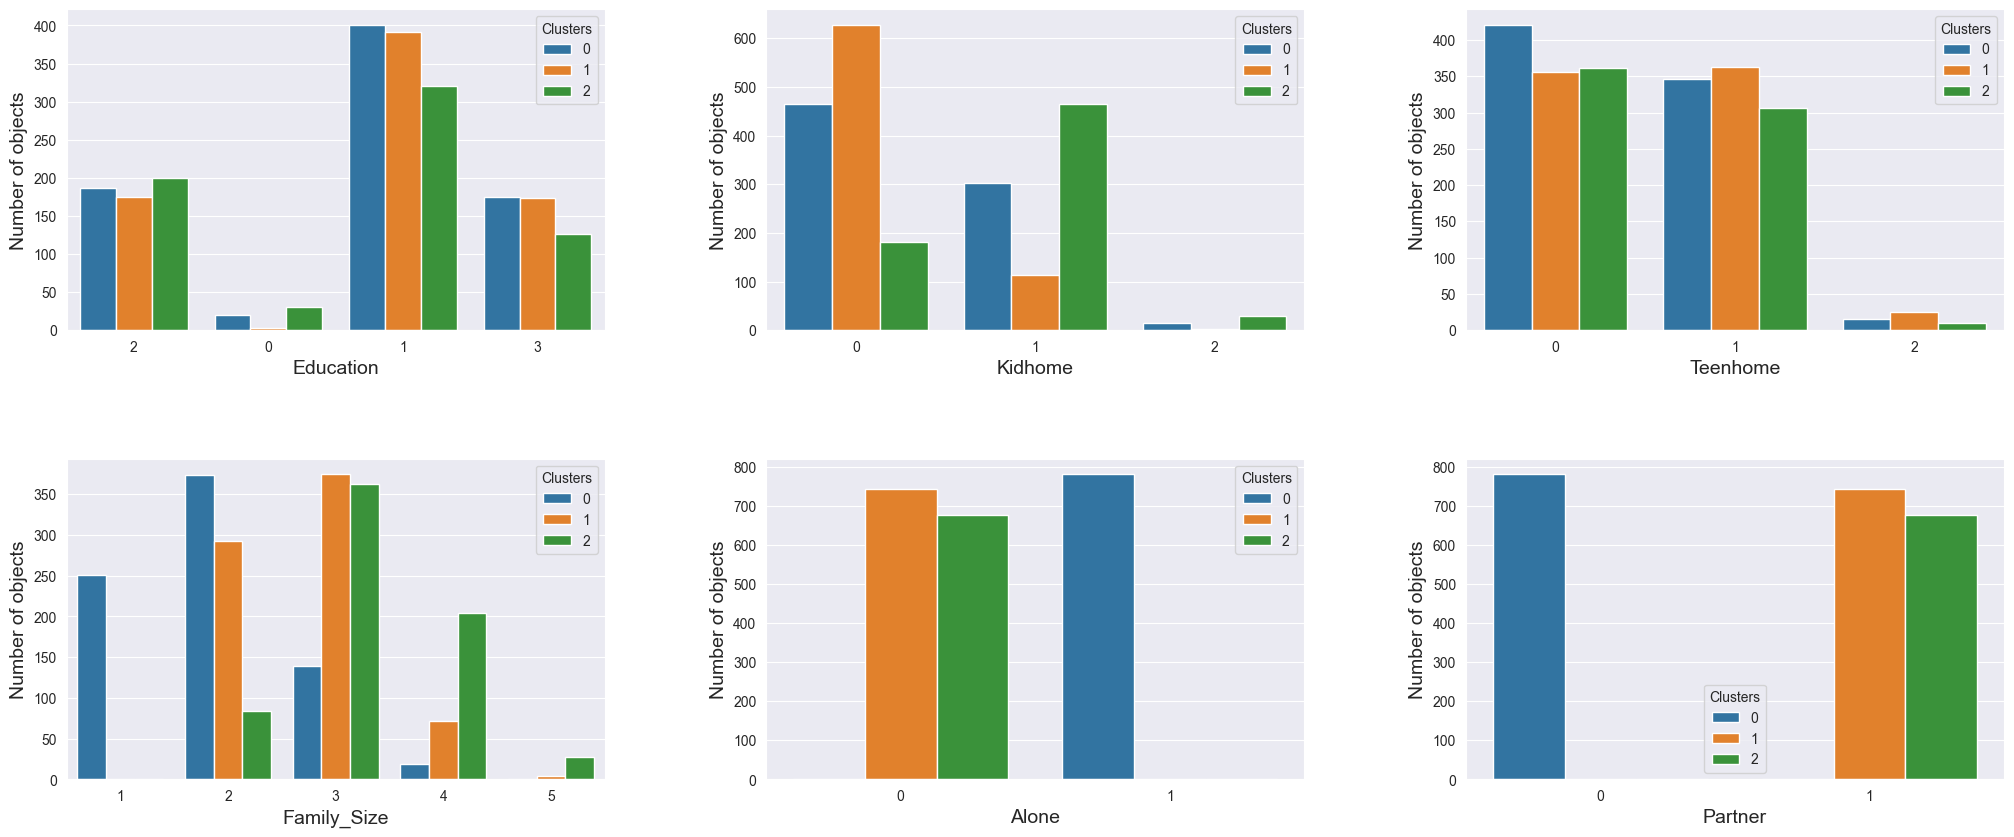

In [44]:
def graph_builder():
    """Graphs of the main characteristics for features int | float for the best models.
    The best model was chosen based on the results of the graphs"""
    def boxplot():
        n_cols = len(num_cols)
        rows = n_cols // 3 
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            b = sns.boxplot(
                 data=df,
                 y=col,
                 x="Clusters",
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
            b.set_xlabel('Clusters', fontsize=14)
            b.set_ylabel(f'{df[col].name}', fontsize=14)
            sns.set_style('darkgrid')
    
    def histplot():    
        n_cols = len(num_cols)
        rows = n_cols // 3
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            h = sns.histplot(
                 data=df,
                 x=col,
                 hue="Clusters",
                 multiple="stack",
                 kde=True,
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
                
            h.set_xlabel(f'{df[col].name}', fontsize=14)
            h.set_ylabel('Count', fontsize=14)
            sns.set_style('darkgrid')
            
    def barplot():
        n_cols = len(object_cols)
        rows = n_cols // 3 + n_cols % 3
        size_cluster = df.groupby("Clusters").count().iloc[:, 0]
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)    
        for num, col in enumerate(object_cols):
            data = (df.groupby(["Clusters"])[col].value_counts().unstack(fill_value=0).T)
            data = pd.DataFrame(data.unstack())
            data.columns = ["Number of objects"]
            data = data.reset_index()
            b= sns.barplot(
                 data=data,
                 x=data[col],
                 hue=data.Clusters,
                 y=data['Number of objects'],
                 ax=axes.reshape(-1)[num])
            b.set_xlabel(f'{data[col].name}', fontsize=14)
            b.set_ylabel('Number of objects', fontsize=14)
            sns.set_style('darkgrid')
    
    boxplot()
    histplot()
    barplot()
    
graph_builder()


 Business Recommendations



As a result of cluster analysis, we received three groups of buyers (clusters):


0 cluster:


Middle income people (average income equals 50000)
Average age is 52 years
Have an education (Graduation, 2n Cycle, Master, PhD)
People without family, people with families with and without children
Quite often buy wines, but they also often buy meat
Most often make purchases on the web
The average number of purchases is 13


1 cluster:


High income people (average income equals 70000)
Average age is 55 years
Have an education (Graduation, 2n Cycle, Master, PhD)
Have a family with children (Teenhome)
Quite often buy wines, but they also often buy meat
Most often make purchases in the stores themselves
Most often make purchases (compared to other clusters)


2 cluster:


Average income equals 38000
Average age is 49 years
Have an education (Graduation, 2n Cycle, Master, PhD)
People with families with and without children
A low number of purchases and, accordingly, spend little money on purchases